

## Location Selection for Delivery Locker for Online Retailers 

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
<ol>
<li> <a href="#item1">Introduction </a>  
    
<li> <a href="#item2">Download and Explore Dataset</a> 

<li> <a href="#item3">Explore Neighborhoods in New York City</a> 

<li> <a href="#item4">Analyze Each Neighborhood</a> 

<li> <a href="#item5">Cluster Neighborhoods</a> 

<li> <a href="#item6">Examine Clusters</a>  
    
</ol>
</font>

</div>

## 1. <a id="item1"></a> Introduction 

In this project, Brooklyn borough neighborhood addresses are converted into their equivalent latitude and longitude values. Then, the Foursquare API is used to explore neighborhoods in Brooklyn borough, New York City. Using the **explore** function , the most common venue categories in each neighborhood is extracted, and then this feature is used to group the neighborhoods into clusters. The *k*-means clustering algorithm is employed to perform this task. Finally, the Folium library is utilized to visualize the neighborhoods in Brooklyn borough and their emerging clusters.

### Loading Libraries

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
# uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
# uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>

## 2. <a id="item2"></a> Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Using this dataset from: https://geo.nyu.edu/catalog/nyu_2451_34572

#### Load and explore the data

Next, let's load the data.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [ ]:
newyork_data

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [4]:
neighborhoods_data = newyork_data['features']

Let's take a look at the fiftieth item in this list.

In [5]:
neighborhoods_data[50]

{'geometry': {'coordinates': [-73.97347087708445, 40.59526001306593],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.51',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Gravesend',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.97347087708445,
   40.59526001306593,
   -73.97347087708445,
   40.59526001306593],
  'borough': 'Brooklyn',
  'name': 'Gravesend',
  'stacked': 1},
 'type': 'Feature'}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [7]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [11]:
address = 'New York City, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

C:\Users\LEKE\Anaconda3\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of New York City are 40.7308619, -73.9871558.


#### Create a map of New York with neighborhoods superimposed on top.

In [12]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for the purposes of this project, let's simplify the above map and segment and cluster only the neighborhoods in Brooklyn. Now, we slice the original dataframe and create a new dataframe of the Brooklyn data.

In [13]:
Brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
Brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


Let's get the geographical coordinates of Brooklyn.

In [14]:
address = 'Brooklyn, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

C:\Users\LEKE\Anaconda3\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


As we did with all of New York City, let's visualize Brooklyn and the neighborhoods in it.

In [15]:
# create map of Brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Brooklyn_data['Latitude'], Brooklyn_data['Longitude'], Brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'KBRDUKHW4O51S5J2OPH4EVWICLKBJLTEEKZKM5FXURTCPTPO' # your Foursquare ID
CLIENT_SECRET = '0F2XJNDKLVX3RQQ2JOW2FCL02L4SRSI12V0W3R02R1V21300' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KBRDUKHW4O51S5J2OPH4EVWICLKBJLTEEKZKM5FXURTCPTPO
CLIENT_SECRET:0F2XJNDKLVX3RQQ2JOW2FCL02L4SRSI12V0W3R02R1V21300


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [17]:
print(Brooklyn_data.loc[0, 'Neighborhood'])
Brooklyn_data.shape

Bay Ridge


(70, 4)

Get the neighborhood's latitude and longitude values.

In [18]:
neighborhood_latitude = Brooklyn_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Brooklyn_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Brooklyn_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bay Ridge are 40.625801065010656, -74.03062069353813.


#### Now, let's get the top 100 venues that are in Bay Ridge within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [19]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url




'https://api.foursquare.com/v2/venues/explore?&client_id=KBRDUKHW4O51S5J2OPH4EVWICLKBJLTEEKZKM5FXURTCPTPO&client_secret=0F2XJNDKLVX3RQQ2JOW2FCL02L4SRSI12V0W3R02R1V21300&v=20180605&ll=40.625801065010656,-74.03062069353813&radius=500&limit=100'

Double-click __here__ for the solution.
<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 

Send the GET request and examine the resutls

In [20]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5bb4286b6a6071445dca87a4'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4b895827f964a5206c2d32e3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/spa_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1ed941735',
         'name': 'Spa',
         'pluralName': 'Spas',
         'primary': True,
         'shortName': 'Spa'}],
       'id': '4b895827f964a5206c2d32e3',
       'location': {'address': '8412 3rd Ave',
        'cc': 'US',
        'city': 'Brooklyn',
        'country': 'United States',
        'distance': 117,
        'formattedAddress': ['8412 3rd Ave',
         'Brooklyn, NY 11209',
         'United States'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.62474788273414,
          'lng

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Pilo Arts Day Spa and Salon,Spa,40.624748,-74.030591
1,Cocoa Grinder,Juice Bar,40.623967,-74.030863
2,Bagel Boy,Bagel Shop,40.627896,-74.029335
3,Pegasus Cafe,Breakfast Spot,40.623168,-74.031186
4,Ho' Brah Taco Joint,Taco Place,40.622960,-74.031371


And how many venues were returned by Foursquare?

In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

87 venues were returned by Foursquare.


<a id='item2'></a>

## 3. <a id="item3"></a> Explore Neighborhoods in Brooklyn

#### Let's create a function to repeat the same process to all the neighborhoods in Brooklyn

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *Brooklyn_venues*.

In [25]:
# type your answer here
Brooklyn_venues = getNearbyVenues(names=Brooklyn_data['Neighborhood'],
                                   latitudes=Brooklyn_data['Latitude'],
                                   longitudes=Brooklyn_data['Longitude']
                                  )


Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [26]:
print(Brooklyn_venues.shape)
Brooklyn_venues.head()

(2808, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
2,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place


Let's check how many venues were returned for each neighborhood

In [103]:
#g1=Brooklyn_venues.groupby('Neighborhood').count()
#g1.add_suffix('_Count').reset_index() convert to dataframe
data=pd.DataFrame({'count' :Brooklyn_venues.groupby('Neighborhood').size()}).reset_index()
data.describe()

,count
count,70.000000
mean,40.114286
std,31.398118
min,2.000000
25%,16.250000
50%,27.000000
75%,65.250000
max,100.000000


Checking the number of venues for each category in Bath Beach Neighborhood

In [87]:
gg=Brooklyn_venues[Brooklyn_venues['Neighborhood']=='Bay Ridge']
gg.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
American Restaurant,2,2,2,2,2,2
Asian Restaurant,2,2,2,2,2,2
Athletics & Sports,1,1,1,1,1,1
Bagel Shop,1,1,1,1,1,1
Bakery,2,2,2,2,2,2
Bar,3,3,3,3,3,3
Beach,1,1,1,1,1,1
Bistro,1,1,1,1,1,1
Burger Joint,1,1,1,1,1,1


#### Let's visualize this in a bar chart

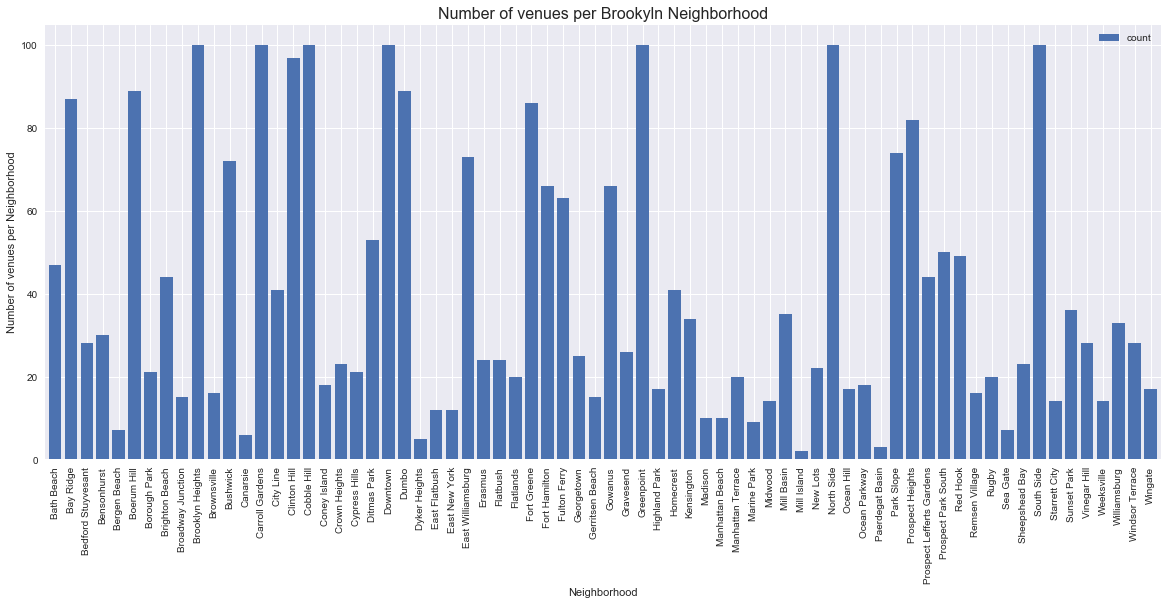

In [102]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
ax=data.set_index('Neighborhood')
ax.plot(kind='bar', figsize=(20, 8), width=0.8)
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of venues per Neighborhood') # add y-label to the plot
plt.title('Number of venues per Brookyln Neighborhood', fontsize=16) # add title to the plot

plt.show()

#### Let's find out how many unique categories can be curated from all the returned venues

In [55]:
print('There are {} uniques categories.'.format(len(Brooklyn_venues['Venue Category'].unique())))

There are 290 uniques categories.


<a id='item3'></a>

## 4. <a id="item4"></a>  Analyze Each Neighborhood

In [56]:
# one hot encoding
Brooklyn_onehot = pd.get_dummies(Brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Brooklyn_onehot['Neighborhood'] = Brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Brooklyn_onehot.columns[-1]] + list(Brooklyn_onehot.columns[:-1])
Brooklyn_onehot = Brooklyn_onehot[fixed_columns]

Brooklyn_onehot.head()

,Yoga Studio,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Books

And let's examine the new dataframe size.

In [57]:
Brooklyn_onehot.shape

(2808, 290)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [58]:
brooklyn_grouped = Brooklyn_onehot.groupby('Neighborhood').mean().reset_index()

#### Let's confirm the new size

In [59]:
brooklyn_grouped.shape

(70, 290)

#### Let's print each neighborhood along with the top 5 most common venues

In [34]:
num_top_venues = 5

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                  venue  freq
0              Pharmacy  0.06
1            Donut Shop  0.06
2  Fast Food Restaurant  0.04
3          Dessert Shop  0.04
4    Italian Restaurant  0.04


----Bay Ridge----
                venue  freq
0  Italian Restaurant  0.07
1                 Spa  0.06
2         Pizza Place  0.06
3          Bagel Shop  0.05
4       Grocery Store  0.03


----Bedford Stuyvesant----
           venue  freq
0    Coffee Shop  0.11
1           Café  0.07
2  Deli / Bodega  0.07
3    Pizza Place  0.07
4            Bar  0.07


----Bensonhurst----
                venue  freq
0  Chinese Restaurant  0.10
1    Sushi Restaurant  0.07
2       Grocery Store  0.07
3        Dessert Shop  0.07
4      Ice Cream Shop  0.07


----Bergen Beach----
                venue  freq
0     Harbor / Marina  0.29
1  Athletics & Sports  0.14
2        Hockey Field  0.14
3          Donut Shop  0.14
4      Baseball Field  0.14


----Boerum Hill----
            venue  freq
0     Coffee Shop  

                venue  freq
0         Pizza Place  0.29
1      Ice Cream Shop  0.07
2            Pharmacy  0.07
3  Italian Restaurant  0.07
4         Candy Store  0.07


----Mill Basin----
                 venue  freq
0          Pizza Place  0.11
1  Japanese Restaurant  0.09
2           Bagel Shop  0.06
3         Burger Joint  0.06
4                 Bank  0.06


----Mill Island----
             venue  freq
0             Pool   0.5
1             Lake   0.5
2      Yoga Studio   0.0
3  Other Nightlife   0.0
4             Park   0.0


----New Lots----
                venue  freq
0         Pizza Place  0.14
1       Grocery Store  0.09
2       Metro Station  0.09
3            Bus Stop  0.09
4  Spanish Restaurant  0.05


----North Side----
                 venue  freq
0          Coffee Shop  0.06
1  American Restaurant  0.05
2                  Bar  0.04
3         Cocktail Bar  0.03
4    French Restaurant  0.03


----Ocean Hill----
                 venue  freq
0        Deli / Bodega  0.18
1   

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Donut Shop,Pharmacy,Women's Store,Dessert Shop,Kids Store,Fast Food Restaurant,Italian Restaurant,Chinese Restaurant,Sandwich Place,Bubble Tea Shop
1,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Bagel Shop,American Restaurant,Grocery Store,Greek Restaurant,Bar,Playground,Mexican Restaurant
2,Bedford Stuyvesant,Coffee Shop,Pizza Place,Deli / Bodega,Café,Bar,Thrift / Vintage Store,Discount Store,Pharmacy,Park,Cocktail Bar
3,Bensonhurst,Chinese Restaurant,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Grocery Store,Dessert Shop,Pizza Place,Spa,Liquor Store,Noodle House
4,Bergen Beach,Harbor / Marina,Athletics & Sports,Baseball Field,Donut Shop,Playground,Hockey Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop
5,Boerum Hill,Coffee Shop,Bar,Dance Studio,Cosmetics Shop,Yoga Studio,Clothing Store,Middle Eastern Restaurant,Mexican Restaurant,Martial Arts Dojo,Spa
6,Borough Park,Deli / Bodega,Bank,Pharmacy,Pizza Place,Music Store,Fast Food Restaurant,Coffee Shop,Metro Station,Bakery,Breakfast Spot
7,Brighton Beach,Beach,Restaurant,Russian Restaurant,Eastern European Restaurant,Bank,Mobile Phone Shop,Sushi Restaurant,Gourmet Shop,Fast Food Restaurant,Pharmacy
8,Broadway Junction,Donut Shop,Diner,Bus Stop,Burger Joint,Grocery Store,Caribbean Restaurant,Food Stand,Sandwich Place,Fried Chicken Joint,Ice Cream Shop
9,Brooklyn Heights,Yoga Studio,Park,Deli / Bodega,Italian Restaurant,Bar,Coffee Shop,Gym,Cosmetics Shop,Pizza Place,Indian Restaurant


<a id='item4'></a>

## 5. <a id="item5"></a> Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [37]:
# set number of clusters
kclusters = 5

brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 0, 4, 4, 0, 1, 4, 1, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [38]:
Brooklyn_merged = Brooklyn_data

# add clustering labels
Brooklyn_merged['Cluster Labels'] = kmeans.labels_

# merge brooklyn_grouped with toronto_data to add latitude/longitude for each neighborhood
Brooklyn_merged = Brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,4,Italian Restaurant,Spa,Pizza Place,Bagel Shop,American Restaurant,Grocery Store,Greek Restaurant,Bar,Playground,Mexican Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,4,Chinese Restaurant,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Grocery Store,Dessert Shop,Pizza Place,Spa,Liquor Store,Noodle House
2,Brooklyn,Sunset Park,40.645103,-74.010316,0,Mexican Restaurant,Latin American Restaurant,Bank,Bakery,Pizza Place,Mobile Phone Shop,Gym,Pharmacy,Chinese Restaurant,Sandwich Place
3,Brooklyn,Greenpoint,40.730201,-73.954241,4,Bar,Pizza Place,Cocktail Bar,Yoga Studio,Bakery,Café,Record Shop,Mexican Restaurant,Coffee Shop,Boutique
4,Brooklyn,Gravesend,40.595260,-73.973471,4,Chinese Restaurant,Pizza Place,Italian Restaurant,Deli / Bodega,Lounge,Spa,Bakery,Music Store,Sporting Goods Shop,Metro Station


Finally, let's visualize the resulting clusters

In [75]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Brooklyn_merged['Latitude'], Brooklyn_merged['Longitude'], Brooklyn_merged['Neighborhood'], Brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 6. <a id="item6"></a> Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [40]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 0, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Sunset Park,Mexican Restaurant,Latin American Restaurant,Bank,Bakery,Pizza Place,Mobile Phone Shop,Gym,Pharmacy,Chinese Restaurant,Sandwich Place
5,Brighton Beach,Beach,Restaurant,Russian Restaurant,Eastern European Restaurant,Bank,Mobile Phone Shop,Sushi Restaurant,Gourmet Shop,Fast Food Restaurant,Pharmacy
9,Crown Heights,Pizza Place,Museum,Café,Playground,Bagel Shop,Burger Joint,Candy Store,Metro Station,Supermarket,Sushi Restaurant
11,Kensington,Grocery Store,Pizza Place,Deli / Bodega,Sandwich Place,Thai Restaurant,Ice Cream Shop,Playground,Liquor Store,Supermarket,Furniture / Home Store
13,Prospect Heights,Bar,Thai Restaurant,Cocktail Bar,Mexican Restaurant,Wine Shop,Pizza Place,Gourmet Shop,American Restaurant,Bakery,Ice Cream Shop
16,Bushwick,Bar,Mexican Restaurant,Coffee Shop,Deli / Bodega,Pizza Place,Bakery,Discount Store,Thrift / Vintage Store,Italian Restaurant,Diner
21,Red Hook,Art Gallery,Seafood Restaurant,Park,Café,Bagel Shop,Farm,Flower Shop,Ice Cream Shop,Wine Shop,American Restaurant
22,Gowanus,Bar,Furniture / Home Store,Italian Restaurant,Gym / Fitness Center,Art Gallery,Deli / Bodega,Mexican Restaurant,Rental Car Location,Nightclub,Coffee Shop
26,East New York,Chinese Restaurant,Spanish Restaurant,Fast Food Restaurant,Caribbean Restaurant,Metro Station,Event Service,Latin American Restaurant,Pharmacy,Pizza Place,Bus Stop
30,Mill Island,Lake,Pool,Women's Store,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop


#### Cluster 2

In [76]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 1, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Sheepshead Bay,Turkish Restaurant,Dessert Shop,Restaurant,Sandwich Place,Yoga Studio,Department Store,Pizza Place,Creperie,Russian Restaurant,Café
8,Flatbush,Coffee Shop,Deli / Bodega,Mexican Restaurant,Caribbean Restaurant,Pharmacy,Bus Station,Liquor Store,Bank,Middle Eastern Restaurant,Donut Shop
17,Bedford Stuyvesant,Coffee Shop,Pizza Place,Deli / Bodega,Café,Bar,Thrift / Vintage Store,Discount Store,Pharmacy,Park,Cocktail Bar
19,Cobble Hill,Pizza Place,Bar,Coffee Shop,Italian Restaurant,Ice Cream Shop,Playground,Yoga Studio,Cocktail Bar,American Restaurant,Deli / Bodega
20,Carroll Gardens,Italian Restaurant,Cocktail Bar,Pizza Place,Bakery,Coffee Shop,Wine Shop,Bar,Gym / Fitness Center,Spa,Gift Shop
24,Park Slope,Pizza Place,American Restaurant,Coffee Shop,Burger Joint,Italian Restaurant,Sushi Restaurant,Falafel Restaurant,Pet Store,Spa,Japanese Restaurant
25,Cypress Hills,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Latin American Restaurant,Spanish Restaurant,Liquor Store,Supermarket,Metro Station,Bakery,Discount Store
27,Starrett City,Pharmacy,Intersection,Moving Target,Caribbean Restaurant,Shoe Store,Supermarket,River,Cosmetics Shop,Gym,Bus Stop
28,Canarsie,Asian Restaurant,Deli / Bodega,Caribbean Restaurant,Gym,Grocery Store,Food,Women's Store,Fish & Chips Shop,Fish Market,Flower Shop
29,Flatlands,Fast Food Restaurant,Pharmacy,Caribbean Restaurant,Lounge,Deli / Bodega,Gym,Video Store,Park,Electronics Store,Restaurant


#### Cluster 3

In [42]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 2, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Windsor Terrace,Deli / Bodega,Park,Plaza,Italian Restaurant,Diner,Food Truck,Middle Eastern Restaurant,Chinese Restaurant,Salad Place,Bookstore
52,Ocean Parkway,Gym,Bagel Shop,Bus Station,Steakhouse,Supermarket,Sushi Restaurant,General Entertainment,Gift Shop,Sake Bar,Gym / Fitness Center


#### Cluster 4

In [43]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 3, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Prospect Park South,Caribbean Restaurant,Fast Food Restaurant,Clothing Store,Grocery Store,Mobile Phone Shop,Pizza Place,Shoe Store,Pharmacy,Women's Store,Donut Shop


#### Cluster 5

In [44]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 4, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Bagel Shop,American Restaurant,Grocery Store,Greek Restaurant,Bar,Playground,Mexican Restaurant
1,Bensonhurst,Chinese Restaurant,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Grocery Store,Dessert Shop,Pizza Place,Spa,Liquor Store,Noodle House
3,Greenpoint,Bar,Pizza Place,Cocktail Bar,Yoga Studio,Bakery,Café,Record Shop,Mexican Restaurant,Coffee Shop,Boutique
4,Gravesend,Chinese Restaurant,Pizza Place,Italian Restaurant,Deli / Bodega,Lounge,Spa,Bakery,Music Store,Sporting Goods Shop,Metro Station
7,Manhattan Terrace,Pizza Place,Donut Shop,Cosmetics Shop,Japanese Restaurant,Grocery Store,Chinese Restaurant,Organic Grocery,Steakhouse,Bank,Convenience Store
10,East Flatbush,Department Store,Pharmacy,Supermarket,Food & Drink Shop,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Hardware Store,Park,Moving Target
14,Brownsville,Moving Target,Pool,Donut Shop,Liquor Store,Burger Joint,Park,Performing Arts Venue,Trail,Chinese Restaurant,Restaurant
15,Williamsburg,Bar,Bagel Shop,Coffee Shop,Taco Place,Japanese Restaurant,Korean Restaurant,Seafood Restaurant,Pizza Place,Pet Store,Park
18,Brooklyn Heights,Yoga Studio,Park,Deli / Bodega,Italian Restaurant,Bar,Coffee Shop,Gym,Cosmetics Shop,Pizza Place,Indian Restaurant
23,Fort Greene,Italian Restaurant,Coffee Shop,Pizza Place,Flower Shop,Opera House,French Restaurant,Spa,Theater,Mexican Restaurant,Cocktail Bar


In [108]:
Brooklyn_venues[Brooklyn_venues['Venue Category']=='Boutique']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
182,Greenpoint,40.730201,-73.954241,Wolves Within,40.731239,-73.957772,Boutique
209,Greenpoint,40.730201,-73.954241,In God We Trust,40.729818,-73.958162,Boutique
221,Greenpoint,40.730201,-73.954241,pas mal,40.729359,-73.957522,Boutique
690,Bedford Stuyvesant,40.687232,-73.941785,Sincerely Tommy,40.686066,-73.944294,Boutique
857,Cobble Hill,40.687920,-73.998561,Marine Layer,40.687393,-73.993448,Boutique
884,Cobble Hill,40.687920,-73.998561,Diane T,40.687797,-73.993175,Boutique
1185,Fort Greene,40.688527,-73.972906,Thistle & Clover,40.689571,-73.970627,Boutique
1440,Bath Beach,40.599519,-73.998752,Effies Boutique,40.603388,-73.996269,Boutique
1558,Clinton Hill,40.693229,-73.967843,Thistle & Clover,40.689571,-73.970627,Boutique
1584,Clinton Hill,40.693229,-73.967843,Brooklyn Stone Boutique,40.693212,-73.971523,Boutique


### Thank you for grading my project!

This notebook was created by [Alex Aklson](https://www.linkedin.com/in/aklson/) and modified for this project by [Leke Ogunranti](https://www.linkedin.com/in/leke-ogunranti-mba-09077049/). I hope you found this project interesting and educational. Feel free to contact me or the course Instructor(Alex) if you have any questions!

This notebook is part of a course on **Coursera** called *Applied Data Science Capstone*. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DP0701EN_Coursera_Week3_LAB2).

<hr>
Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).